# load and install needed packages



In [2]:
import pandas as pd
import numpy as np
import glob
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from xml.dom import minidom
from skimage import io
!pip install xmltodict
import xmltodict


from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


# load images and labels 

In [5]:
# define an image loader fuction
def load_image(infilename):
  img = io.imread(infilename)
  data = np.asarray(img)
  return data

# load images of the Boxes
X = []
filenames = []
for filename in glob.glob('/content/drive/MyDrive/DeepVis/Data/Camfront/Camfront_uncropped/*.jpg'):
  X.append(load_image(filename))
  filenames.append(filename.split('/')[-1])

# load xml data with labels as dict
files_list = []
for file in glob.glob('/content/drive/MyDrive/DeepVis/Data/Camfront/Camfront_uncropped/*.xml'):
    with open(file) as fd:
        files_list.append(xmltodict.parse(fd.read()))


# define functions to help generating a dataframe from dict (the relevant data is located
# at different indeces for different xml files)
def extract_data_in_dict16(file):
    dict_temp = {}
    for i in file["annotation"]["object"][16]["bndbox"].items():
      dict_temp[i[0]] = i[1] 
    return dict_temp

def extract_data_in_dict17(file):
    dict_temp = {}
    for i in file["annotation"]["object"][17]["bndbox"].items():
      dict_temp[i[0]] = i[1] 
    return dict_temp 

def extract_data_in_dict3(file):
    dict_temp = {}
    for i in file["annotation"]["object"][-3]["bndbox"].items():
      dict_temp[i[0]] = i[1] 
    return dict_temp

  
# iterate through each dict to create dataframe
temp_list = []
names = []

for i in files_list:
  if i["annotation"]["object"][-3]["name"] == "CamFront":
    temp_list.append(extract_data_in_dict3(i))
  elif i["annotation"]["object"][17]["name"] == "CamFront":
    extract_data_in_dict17(i)
  else:
    temp_list.append(extract_data_in_dict16(i))

df = pd.DataFrame(temp_list)

for i in files_list:
    names.append(i["annotation"]["filename"])

df["filename"] = names


### create the labels and have a look at the perfect bb ###

# extract the x and y values for each bb label into list 
y = []
for filename in filenames:
  xmin = int(df[df['filename'] == filename]['xmin'])
  xmax = int(df[df['filename'] == filename]['xmax'])
  ymin = int(df[df['filename'] == filename]['ymin'])
  ymax = int(df[df['filename'] == filename]['ymax'])
  y.append((xmin, ymin, xmax, ymax))

# function to create image with bb
def create_img_with_bb(img, bb):
  fig, ax = plt.subplots()
  ax.imshow(img)
  rect = patches.Rectangle((bb[0], bb[1]), (bb[2]-bb[0]), (bb[3]-bb[1]), linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

# look at all images with bb

'''
for i in range(len(y)):
  print(df["filename"][i])
  create_img_with_bb(X[i], y[i])
'''





'\nfor i in range(len(y)):\n  print(df["filename"][i])\n  create_img_with_bb(X[i], y[i])\n'

# Datasets und Dataloader

In [6]:
X = np.array(X)
y = np.array(y)

# Train and Val Set

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2)

#Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data).float()
        self.targets = torch.tensor(targets).float()
        
    def __getitem__(self, index):
        x = self.data[index]
        x = x.transpose(0, 2).transpose(1,2)
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

print(f"X: {len(X)}")
print(f"X_train: {len(X_train)}")
print(f"X_val: {len(X_val)}")
print(f"X_test: {len(X_test)}")


ValueError: ignored

# Augmentations

In [ ]:
# Normalie Images 
val_and_test_transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     
    ],
    bbox_params = A.BboxParams(format="pascal_voc",min_area=2048, min_visibility=0.3, 
                                   label_fields=[]))


# apply normalization on all data 
images_list_train = []
bb_list_train = []

for i in range(len(X_train)):
  augmentations = train_transform(image=X_train[i],bboxes = [y_train[i]]) #ergibt dictionary
  augmented_img = augmentations["image"]
  images_list_train.append(augmented_img)
  bb_list_train.append(augmentations["bboxes"][0]) 
   
'''
for i in range(len(X_train)):
  augmentations = train_transform(image=X_train[i],bboxes = [y_train[i]]) #ergibt dictionary
  augmented_img = augmentations["image"]
  images_list_train.append(augmented_img)
  bb_list_train.append(augmentations["bboxes"][0]) 

for i in range(2):
  for i in range(len(images_without_errorbox)):
    augmentations = train_transform(image=X_train[i],bboxes = [y_train[i]]) #ergibt dictionary
    augmented_img = augmentations["image"]
    images_list_train.append(augmented_img)
    bb_list_train.append(augmentations["bboxes"][0]) 

'''

images_list_val =[]
bb_list_val = []


for i in range(len(X_val)):
  augmentations = val_and_test_transform(image=X_val[i],bboxes = [y_val[i]]) 
  augmented_img = augmentations["image"]
  images_list_val.append(augmented_img)
  bb_list_val.append(augmentations["bboxes"][0]) 

images_list_test =[]
bb_list_test = []

for i in range(len(X_test)):
  augmentations = val_and_test_transform(image=X_test[i],bboxes = [y_test[i]]) 
  augmented_img = augmentations["image"]
  images_list_test.append(augmented_img)
  bb_list_test.append(augmentations["bboxes"][0]) 

In [ ]:
#Load images as Dataset

images_list_train = np.array(images_list_train)
bb_list_train = np.array(bb_list_train)
images_list_val = np.array(images_list_val)
bb_list_val = np.array(bb_list_val)

images_list_train = torch.tensor(images_list_train)
bb_list_train = torch.tensor(bb_list_train)
images_list_val = torch.tensor(images_list_val)
bb_list_val = torch.tensor(bb_list_val)

train_data = MyDataset(images_list_train, bb_list_train)
val_data = MyDataset(images_list_val, bb_list_val)

images_list_test = np.array(images_list_test)
bb_list_test = np.array(bb_list_test)

test_data = MyDataset(images_list_test, bb_list_test)

<ipython-input-5-7c73cfe1c308>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data).float()
<ipython-input-5-7c73cfe1c308>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets).float()


In [ ]:
# Add train and val dataset to dataloader
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

# From-Scratch Network

In [ ]:
# Hyperparameter bestimmen 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1158248, out_features=64)  
        self.fc2 = nn.Linear(in_features=64, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(len(x), 1158248)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Netz trainieren
net = Net().to('cuda')

optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
loss_fct = nn.MSELoss()

train_losses = []
val_losses = []
for t in range(20):
  net.train()

  epoch_train_loss = 0.
  for X_batch, y_batch in train_dataloader:
    X_batch = X_batch.to('cuda')
    y_batch = y_batch.to('cuda')

    y_pred = net(X_batch)

    loss = loss_fct(y_pred.squeeze(), y_batch.float())
    epoch_train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(epoch_train_loss.cpu().data / len(train_dataloader))

  net.eval()
  epoch_val_loss = 0.
  
  for X_batch, y_batch in val_dataloader:
    X_batch = X_batch.to('cuda')
    y_batch = y_batch.to('cuda')
    with torch.no_grad():
      y_pred_val = net(X_batch)
      loss = loss_fct(y_pred_val.squeeze(), y_batch.float())
      epoch_val_loss += loss
  val_losses.append(epoch_val_loss.cpu().data / len(val_dataloader))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


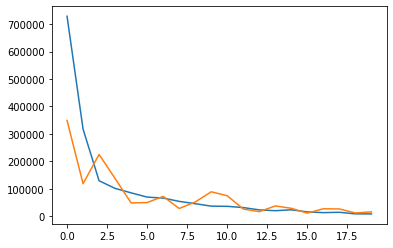

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
# compare the trouth and prediction
for i in range(len(bb_list_test)):
  print(f"ground trouth: {bb_list_test[i]}")
  create_img_with_bb(images_list_test[i], bb_list_test[i])
  print("prediction: " + str(net(test_data[i][0].unsqueeze(0).to("cuda")).tolist()[0]))
  create_img_with_bb(images_list_test[i], net(test_data[i][0].unsqueeze(0).to("cuda")).tolist()[0])
  print("\n")

In [ ]:
# calculate IoU
from torchvision import ops

y_true = []
for i in range(len(bb_list_test)):
  y_true.append("positive")

IOU = []

for i in range(len(bb_list_test)):
  ground_truth_bbox = torch.tensor([bb_list_test[0]], dtype=torch.float)
  prediction_bbox = torch.tensor([net(test_data[i][0].unsqueeze(0).to("cuda")).tolist()[0]], dtype=torch.float)
  iou=ops.box_iou(ground_truth_bbox, prediction_bbox)
  IOU += [iou.numpy()[0][0]]
  print("IuU " + str(i) + " :" + str(iou.numpy()[0][0]))

threshold = 0.9
y_pred = ["positive" if score >= threshold else "negative" for score in IOU]

print(y_true)
print(y_pred)

precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
print(f"percision: {precision}")

recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
print(f"recall: {recall}")

print()
print("AVG IoU: " + str(sum(IOU)/len(bb_list_test)))

IuU 0 :0.8421207
IuU 1 :0.8224494
IuU 2 :0.8328258
IuU 3 :0.8684487
IuU 4 :0.48324287
IuU 5 :0.6359042
IuU 6 :0.5338057
IuU 7 :0.8420225
IuU 8 :0.8177159
IuU 9 :0.58948994
['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative']
percision: 0.0
recall: 0.0

AVG IoU: 0.7268025636672973


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
